# Accessing CORDEX datasets from ESGF

In this example, we will show some ways to access ESGF data using opendap access to ESGF. We want to avoid downloading files to make our research more automatic and reproducable for others.

In [1]:
import cf_xarray as cfxr
import pyesgf
import xarray as xr
from pyesgf.logon import LogonManager
from pyesgf.search import SearchConnection

print(pyesgf.__version__)

lm = LogonManager()

if not lm.is_logged_on():
    myproxy_host = "esgf-data.dkrz.de"
    lm.logon(hostname=myproxy_host, interactive=True, bootstrap=True)


print(f"logged on: {lm.is_logged_on()}")

0.3.1
logged on: True


Theoretically, we can find out the opendap URL for a CORDEX dataset by browsing through the [ESGF Web API](https://esgf-data.dkrz.de/search/cordex-dkrz/). Let's assume, we have found out the URL and want to access that dataset. We can simply use `xr.open_dataset` for this assuming we have `netcdf4` installed.

In [2]:
ds = xr.open_dataset(
    "http://esgf1.dkrz.de/thredds/dodsC/cordex/cordex/output/EUR-11/GERICS/ECMWF-ERAINT/evaluation/r0i0p0/GERICS-REMO2015/v1/fx/orog/v20180813/orog_EUR-11_ECMWF-ERAINT_evaluation_r0i0p0_GERICS-REMO2015_v1_fx.nc"
)

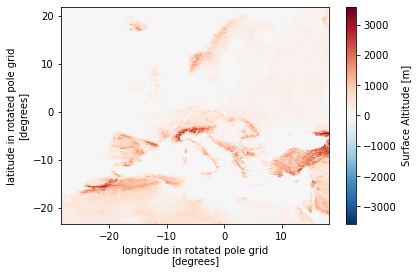

In [3]:
ds.orog.plot()

## Search for URLs

In [4]:
import xml.etree.ElementTree as ET

import numpy
import requests


def parse_urls(response):
    types = {}
    for r in response:
        url_type = r.split("|")[1]
        if "opendap" in url_type:
            types["opendap"] = r.split("|")[0][0:-5]
        else:
            types[url_type] = r.split("|")[0]
    return types
    # return {r.split("|")[1]: r.split("|")[0] for r in response}


def parse_result(response):
    files = response.json()["response"]["docs"]
    # return files
    # result = dict.fromkeys([f['dataset_id'] for f in files], {})
    result = {f["dataset_id"]: {} for f in files}
    for f in files:
        id = f["dataset_id"]
        urls = parse_urls(f["url"])
        for url_type, url in urls.items():
            if url_type in result[id].keys():
                result[id][url_type].append(url)
            else:
                result[id][url_type] = [url]
        # result[id].update(urls)
    return result


def esgf_search(
    url="https://esgf-node.llnl.gov/esg-search/search",
    files_type="OPENDAP",
    local_node=True,
    project="CORDEX",
    **search,
):
    params = dict(
        project=project, type="File", format="application/solr+json", limit=500
    )
    params.update(search)
    response = requests.get(url, params)
    return parse_result(response)

In [5]:
result = esgf_search(
    url="http://esgf-data.dkrz.de/esg-search/search",
    project=["CORDEX", "CORDEX-Reklies"],
    time_frequency="mon",
    variable="tas",
    experiment=["historical", "rcp26", "rcp45", "rcp85"],
    domain="EUR-11",
    ensemble="r1i1p1",
)
len(result)

59

In [6]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51264,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:51354,Total threads: 1
Dashboard: http://127.0.0.1:51361/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:51270,


In [7]:
def open_mfdataset(
    files,
    use_cftime=True,
    parallel=True,
    data_vars="minimal",
    chunks={},
    coords="minimal",
    compat="override",
    drop=None,
    **kwargs,
):
    """optimized function for opening large cf datasets.

    based on https://github.com/pydata/xarray/issues/1385#issuecomment-561920115

    """

    def drop_all_coords(ds):
        # ds = ds.drop(drop)
        return ds.reset_coords(drop=True)

    ds = xr.open_mfdataset(
        files,
        parallel=parallel,
        decode_times=False,
        combine="by_coords",
        preprocess=drop_all_coords,
        decode_cf=False,
        chunks=chunks,
        data_vars=data_vars,
        coords="minimal",
        compat="override",
        **kwargs,
    )
    return xr.decode_cf(ds, use_cftime=use_cftime)

In [8]:
urls = result[
    "cordex.output.EUR-11.DMI.ICHEC-EC-EARTH.historical.r1i1p1.HIRHAM5.v1.mon.tas.v20190108|cordexesg.dmi.dk"
]["opendap"]
%time ds = open_mfdataset(urls, parallel=True, chunks={})

CPU times: user 1.77 s, sys: 758 ms, total: 2.53 s
Wall time: 10.6 s


In [9]:
%time mean = ds.tas.groupby('time.year').mean('time').cf.mean(('X', 'Y')).compute()

CPU times: user 4.75 s, sys: 961 ms, total: 5.72 s
Wall time: 44.3 s


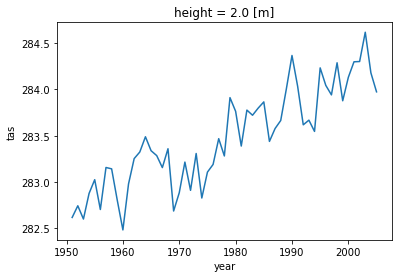

In [10]:
mean.plot()

In [11]:
%%time
import warnings

warnings.filterwarnings("ignore")
# dsets = {key: xr.open_mfdataset(urls['opendap'], parallel=True) for key, urls in result.items()}
dsets = {}
for dset_id, urls in result.items():
    try:
        print(f"opening: {dset_id}")
        dsets[dset_id] = open_mfdataset(urls["opendap"], parallel=True)
    except Exception as e:
        print(f"failed to open: {dset_id}, {e}")

opening: cordex-reklies.output.EUR-11.CLMcom-BTU.MPI-M-MPI-ESM-LR.rcp26.r1i1p1.CCLM4-8-17.v1.mon.tas.v20171121|esgf1.dkrz.de
opening: cordex-reklies.output.EUR-11.CLMcom.CCCma-CanESM2.historical.r1i1p1.CCLM4-8-17.v1.mon.tas.v20171121|esgf1.dkrz.de
opening: cordex-reklies.output.EUR-11.CLMcom.CCCma-CanESM2.rcp85.r1i1p1.CCLM4-8-17.v1.mon.tas.v20171121|esgf1.dkrz.de
opening: cordex-reklies.output.EUR-11.CLMcom.MIROC-MIROC5.historical.r1i1p1.CCLM4-8-17.v1.mon.tas.v20171121|esgf1.dkrz.de
opening: cordex-reklies.output.EUR-11.CLMcom.MIROC-MIROC5.rcp85.r1i1p1.CCLM4-8-17.v1.mon.tas.v20171121|esgf1.dkrz.de
opening: cordex-reklies.output.EUR-11.GERICS.CCCma-CanESM2.historical.r1i1p1.REMO2015.v1.mon.tas.v20170329|esgf1.dkrz.de
opening: cordex-reklies.output.EUR-11.GERICS.CCCma-CanESM2.rcp85.r1i1p1.REMO2015.v1.mon.tas.v20170329|esgf1.dkrz.de
opening: cordex-reklies.output.EUR-11.GERICS.CNRM-CERFACS-CNRM-CM5.historical.r1i1p1.REMO2015.v1.mon.tas.v20170208|esgf1.dkrz.de
opening: cordex-reklies.outpu

syntax error, unexpected $end, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: ^
syntax error, unexpected $end, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: ^
syntax error, unexpected $end, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: ^
syntax error, unexpected $end, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: ^
2023-03-11 17:21:08,308 - distributed.worker - WARNING - Compute Failed
Key:       open_dataset-35e3dd99-26b1-4b6e-b130-2d87266d3503
Function:  execute_task
args:      ((<function apply at 0x109d5e320>, <function open_dataset at 0x13ef43b50>, ['https://esgf.dwd.de/thredds/dodsC/esgf2_1/cordex/output/EUR-11/CLMcom/MIROC-MIROC5/rcp26/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/tas/v20180707/tas_EUR-11_MIROC-MIROC5_rcp26_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_207101-208012.nc'], (<class 'dict'>, [['engine', None], ['chunks', (<class 'dict'>, [])], ['decode_times', False], ['decode_cf', False]])))
kwargs:    {}
Exception: "OSError(-90, 'NetCDF: fi

failed to open: cordex.output.EUR-11.CLMcom.MIROC-MIROC5.rcp26.r1i1p1.CCLM4-8-17.v1.mon.tas.v20180707|esgf.dwd.de, [Errno -90] NetCDF: file not found: b'https://esgf.dwd.de/thredds/dodsC/esgf2_1/cordex/output/EUR-11/CLMcom/MIROC-MIROC5/rcp26/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/tas/v20180707/tas_EUR-11_MIROC-MIROC5_rcp26_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_207101-208012.nc'
opening: cordex.output.EUR-11.CLMcom.MOHC-HadGEM2-ES.historical.r1i1p1.CCLM4-8-17.v1.mon.tas.v20150320|esgf1.dkrz.de


^
syntax error, unexpected $end, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: ^
syntax error, unexpected $end, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: ^
2023-03-11 17:21:08,511 - distributed.worker - WARNING - Compute Failed
Key:       open_dataset-423b7f59-82e4-4514-acea-7f3aaafd1e62
Function:  execute_task
args:      ((<function apply at 0x109d5e320>, <function open_dataset at 0x13ef43b50>, ['https://esgf.dwd.de/thredds/dodsC/esgf2_1/cordex/output/EUR-11/CLMcom/MIROC-MIROC5/rcp26/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/tas/v20180707/tas_EUR-11_MIROC-MIROC5_rcp26_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_202101-203012.nc'], (<class 'dict'>, [['engine', None], ['chunks', (<class 'dict'>, [])], ['decode_times', False], ['decode_cf', False]])))
kwargs:    {}
Exception: "OSError(-90, 'NetCDF: file not found')"

syntax error, unexpected $end, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: ^
2023-03-11 17:21:08,531 - distributed.worker - WARNING - Compute Failed
K

opening: cordex.output.EUR-11.CLMcom.MOHC-HadGEM2-ES.rcp45.r1i1p1.CCLM4-8-17.v1.mon.tas.v20150320|esgf1.dkrz.de
opening: cordex.output.EUR-11.CLMcom.MOHC-HadGEM2-ES.rcp85.r1i1p1.CCLM4-8-17.v1.mon.tas.v20150320|esgf1.dkrz.de
opening: cordex.output.EUR-11.CLMcom.MPI-M-MPI-ESM-LR.historical.r1i1p1.CCLM4-8-17.v1.mon.tas.v20140515|esgf1.dkrz.de
opening: cordex.output.EUR-11.CLMcom.MPI-M-MPI-ESM-LR.rcp45.r1i1p1.CCLM4-8-17.v1.mon.tas.v20140515|esgf1.dkrz.de
opening: cordex.output.EUR-11.CLMcom.MPI-M-MPI-ESM-LR.rcp85.r1i1p1.CCLM4-8-17.v1.mon.tas.v20140515|esgf1.dkrz.de
opening: cordex.output.EUR-11.CNRM.CNRM-CERFACS-CNRM-CM5.historical.r1i1p1.ALADIN53.v1.mon.tas.v20150127|esg1.umr-cnrm.fr
opening: cordex.output.EUR-11.CNRM.CNRM-CERFACS-CNRM-CM5.historical.r1i1p1.ALADIN63.v2.mon.tas.v20190510|esg1.umr-cnrm.fr
opening: cordex.output.EUR-11.CNRM.CNRM-CERFACS-CNRM-CM5.rcp26.r1i1p1.ALADIN53.v1.mon.tas.v20150127|esg1.umr-cnrm.fr
opening: cordex.output.EUR-11.CNRM.CNRM-CERFACS-CNRM-CM5.rcp26.r1i1p1.A

In [12]:
%%time
means = xr.concat(
    [
        ds.tas.groupby("time.year").mean("time").cf.mean(("X", "Y"))
        for ds in dsets.values()
    ],
    dim=xr.DataArray(list(dsets.keys()), dims="dset"),
)

CPU times: user 13.3 s, sys: 1.18 s, total: 14.5 s
Wall time: 36.8 s


In [13]:
%%time
means_ = means.compute()

CPU times: user 10min 32s, sys: 2min 53s, total: 13min 26s
Wall time: 1h 12min 19s


In [22]:
means_.to_netcdf("EUR-11-yearly-means.nc")

In [24]:
means = xr.open_dataset("EUR-11-yearly-means.nc")

# filter dataset id, remove version and source
means["dset"] = [".".join(str(ds.data).split(".")[0:10]) for ds in means.dset]

In [25]:
means

<xarray.Dataset>
Dimensions:  (year: 153, dset: 58)
Coordinates:
  * year     (year) int64 1948 1949 1950 1951 1952 ... 2096 2097 2098 2099 2100
    height   (dset) float64 ...
  * dset     (dset) <U96 'cordex-reklies.output.EUR-11.CLMcom-BTU.MPI-M-MPI-E...
Data variables:
    tas      (dset, year) float32 ...

split dataset by scenario

In [52]:
dsets = {
    exp: means.where(means.dset.str.contains(exp), drop=True).assign_coords(
        experiment=exp
    )  # .dset.str.replace(f".{exp}", "")
    for exp in ["historical", "rcp26", "rcp45", "rcp85"]
}

In [93]:
dsets = {}

for exp in ["historical", "rcp26", "rcp45", "rcp85"]:
    dset = means.where(
        means.dset.str.contains(exp), drop=True
    )  # .assign_coords(experiment=exp)
    dset["dset"] = dset.dset.str.replace(f".{exp}", "")
    dsets[exp] = dset

for exp in ["rcp26", "rcp45", "rcp85"]:
    dsets[exp] = xr.concat([dsets["historical"], dsets[exp]], dim="year").assign_coords(
        experiment=exp
    )

In [103]:
dsets.keys()

dict_keys(['historical', 'rcp26', 'rcp45', 'rcp85'])

In [82]:
(rcp26.where(rcp26.tas > 100, drop=True).tas - 273.5).plot(hue="dset", figsize=(20, 10))

<xarray.Dataset>
Dimensions:     (dset: 26, year: 306)
Coordinates:
  * dset        (dset) <U85 'cordex-reklies.output.EUR-11.CLMcom-BTU.MPI-M-MP...
  * year        (year) int64 1948 1949 1950 1951 1952 ... 2097 2098 2099 2100
    height      (year, dset) float64 nan 2.0 2.0 2.0 2.0 ... nan nan nan nan 2.0
    experiment  (year) <U10 'historical' 'historical' ... 'rcp26' 'rcp26'
Data variables:
    tas         (dset, year) float32 nan nan nan nan nan ... nan nan nan nan nan

concat historical

In [42]:
for exp in ["rcp26", "rcp45", "rcp85"]:
    pass

In [ ]:
rcp45 = means.where(means.dset.str.contains("rcp45"), drop=True).assign_coords(
    experiment="rcp45"
)
historical = means.where(
    means.dset.str.contains("historical"), drop=True
).assign_coords(experiment="historical")

rcp45["dset"] = rcp45.dset.str.replace(".rcp45", "")
historical["dset"] = historical.dset.str.replace(".historical", "")

In [ ]:
concat = xr.concat([historical, rcp45], dim="experiment")

In [ ]:
concat.tas.plot(col="dset", col_wrap=8, hue="experiment")

In [ ]:
concat.tas.sel(experiment="historical").plot(hue="dset", figsize=(20, 10))
concat.tas.sel(experiment="rcp45").plot(hue="dset", figsize=(20, 10))